In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '3'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [3]


In [ ]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
from blackjax import normal_random_walk

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys

from bamojax.base import Model
from bamojax.samplers import gibbs_sampler
from bamojax.inference import SMCInference
from bamojax.more_distributions import AutoRegressionFactory


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


# AR models

The autoregressive model of order $p$ is defined as:
$$
\begin{align*}
    \epsilon &\sim \mathcal{N}(0, \sigma)\\
    x(t) &= x_0 + \sum_{i=1}^p\beta_i x(t-i) + \epsilon
\end{align*}
$$

## AR(1) processes

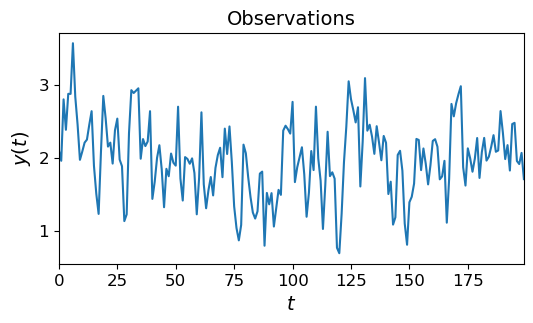

In [4]:
def ar_p_fn(y_prev, coefficients, intercept, **kwargs):
    return intercept + jnp.dot(coefficients, y_prev)

#

state = dict(intercept=1.0, 
             coefficients=jnp.array([0.5]),
             y0=jnp.array([2.1]),
             scale=.4,
             T=200)


AR_node = AutoRegressionFactory(ar_fn=ar_p_fn)(**state)
sample = AR_node._sample_predictive(jrnd.PRNGKey(0))

plt.figure(figsize=(6, 3))
plt.plot(sample)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.xlim([0, state['T']-1])
plt.title('Observations', fontsize=MEDIUM_SIZE);

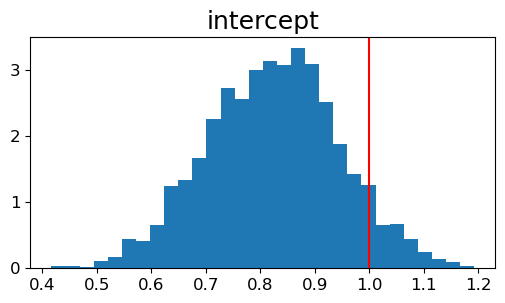

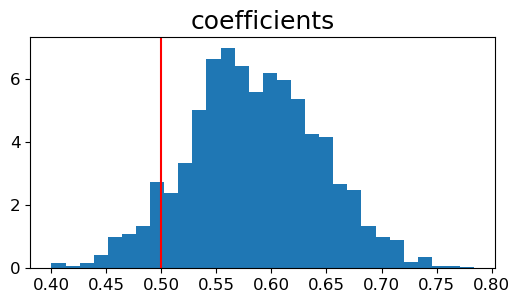

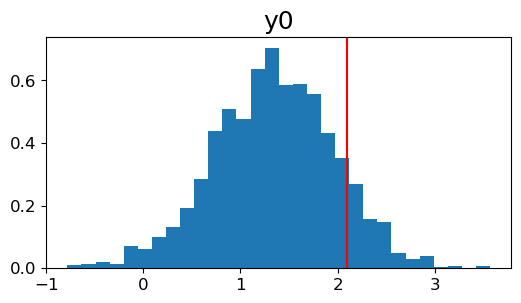

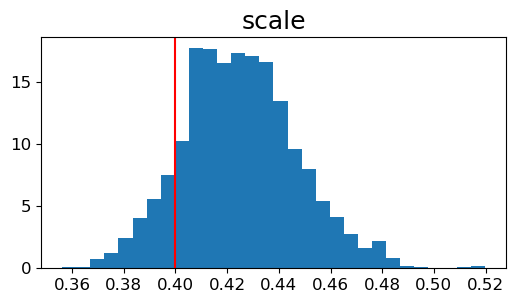

In [5]:
ar1_model = Model('AR(1)')
intercept_node = ar1_model.add_node('intercept', distribution=dx.Normal(loc=jnp.zeros((1,)), scale=jnp.ones((1, ))))
coefficients_node = ar1_model.add_node('coefficients', distribution=dx.Normal(loc=jnp.zeros((1,)), scale=jnp.ones((1, ))))
y0_node = ar1_model.add_node('y0', dx.Normal(loc=jnp.zeros((1,)), scale=jnp.ones((1, ))))
scale_node = ar1_model.add_node('scale', distribution=dx.Transformed(dx.Normal(loc=0.0, scale=1.0), tfb.Exp()))

y_node = ar1_model.add_node('y(t)', 
                            distribution=AutoRegressionFactory(ar_fn=ar_p_fn), 
                            observations=sample, 
                            parents=dict(coefficients=coefficients_node, y0=y0_node, scale=scale_node, intercept=intercept_node))

step_fns = dict(intercept=normal_random_walk, 
                coefficients=normal_random_walk, 
                y0=normal_random_walk, 
                scale=normal_random_walk)
step_fn_params = dict(intercept=dict(sigma=0.1), 
                      coefficients=dict(sigma=0.1), 
                      y0=dict(sigma=0.1), 
                      scale=dict(sigma=0.1))

gibbs = gibbs_sampler(ar1_model, step_fns=step_fns, step_fn_params=step_fn_params)
engine = SMCInference(model=ar1_model, mcmc_kernel=gibbs, num_particles=2000, num_mutations=100, num_chains=1)
results = engine.run(jrnd.PRNGKey(0))

nbins = 30
for var in step_fns.keys():
    plt.figure(figsize=(6, 3))
    plt.hist(results['final_state'].particles[var], density=True, bins=nbins)
    plt.axvline(x=state[var], color='r')
    plt.title(var);

## AR(2) process

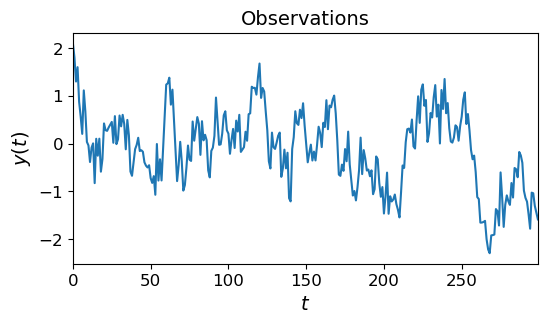

In [6]:
def ar_p_fn(y_prev, coefficients, intercept, **kwargs):
    return intercept + jnp.dot(coefficients, y_prev)

#

state = dict(intercept=0.0, 
             coefficients=jnp.array([0.1, 0.8]),  # note: the smallest lag is the last coefficient
             y0=jnp.array([2.1, 1.8]),
             scale=.4,
             T=300)


AR_node = AutoRegressionFactory(ar_fn=ar_p_fn)(**state)
sample = AR_node._sample_predictive(jrnd.PRNGKey(0))

plt.figure(figsize=(6, 3))
plt.plot(sample)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.xlim([0, state['T']-1])
plt.title('Observations', fontsize=MEDIUM_SIZE);

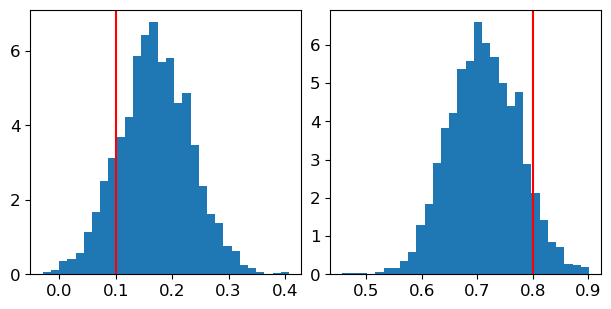

In [7]:
p = 2

arp_model = Model(f'AR({p})')
intercept_node = arp_model.add_node('intercept', distribution=dx.Normal(loc=jnp.zeros((1,)), scale=jnp.ones((1, ))))
coefficients_node = arp_model.add_node('coefficients', distribution=dx.Normal(loc=jnp.zeros((p, )), scale=jnp.ones((p, ))))
y0_node = arp_model.add_node('y0', dx.Normal(loc=jnp.zeros((p, )), scale=jnp.ones((p, ))))
scale_node = arp_model.add_node('scale', distribution=dx.Transformed(dx.Normal(loc=0.0, scale=1.0), tfb.Exp()))

y_node = arp_model.add_node('y(t)', 
                            distribution=AutoRegressionFactory(ar_fn=ar_p_fn), 
                            observations=sample, 
                            parents=dict(coefficients=coefficients_node, 
                                         y0=y0_node, 
                                         scale=scale_node, 
                                         intercept=intercept_node))

step_fns = dict(intercept=normal_random_walk, 
                coefficients=normal_random_walk, 
                y0=normal_random_walk, 
                scale=normal_random_walk)
step_fn_params = dict(intercept=dict(sigma=0.1), 
                      coefficients=dict(sigma=0.1*jnp.eye(p)), 
                      y0=dict(sigma=0.1*jnp.eye(p)), 
                      scale=dict(sigma=0.1))

gibbs = gibbs_sampler(arp_model, step_fns=step_fns, step_fn_params=step_fn_params)
engine = SMCInference(model=arp_model, mcmc_kernel=gibbs, num_particles=2000, num_mutations=100, num_chains=1)
results = engine.run(jrnd.PRNGKey(0))

coefficients_posterior = results['final_state'].particles['coefficients'][:, ::-1]
nbins = 30
_, axes = plt.subplots(nrows=1, ncols=p, constrained_layout=True, figsize=(3*p, 3))
for i, ax in enumerate(axes):
    ax.hist(coefficients_posterior[:, i], density=True, bins=nbins)
    ax.axvline(x=state['coefficients'][i], color='r')

## Mean-reverting AR process

A mean-reverting AR process may be defined as:

$$
\begin{align*}
    \epsilon &\sim \mathcal{N}(0, \sigma)\\
    x(t) &= x_0 + x(t-1) + \kappa\left(\mu-x(t-1)\right) + \epsilon \enspace,
\end{align*}
$$ with $\mu$ the mean and $\kappa$ the strength at which the process reverts back to it.

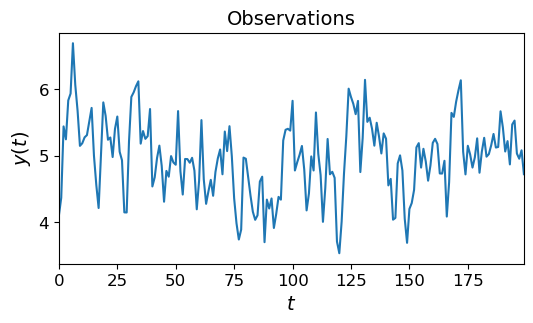

In [8]:
def ar_ou_fn(y_prev, mean, reversion, **kwargs):
    return y_prev[0] + reversion*(mean - y_prev[0])

#

state = dict(mean=5.0,
             reversion=0.4,
             y0=jnp.asarray([4.1]),
             scale=.4,
             T=200)

OU_node = AutoRegressionFactory(ar_fn=ar_ou_fn)(**state)
sample = OU_node._sample_predictive(jrnd.PRNGKey(0))

plt.figure(figsize=(6, 3))
plt.plot(sample)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.xlim([0, state['T']-1])
plt.title('Observations', fontsize=MEDIUM_SIZE);

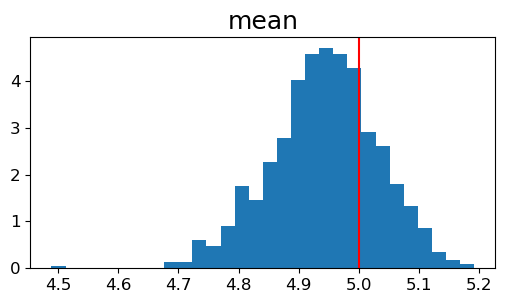

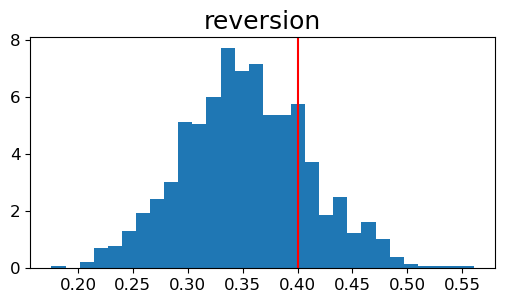

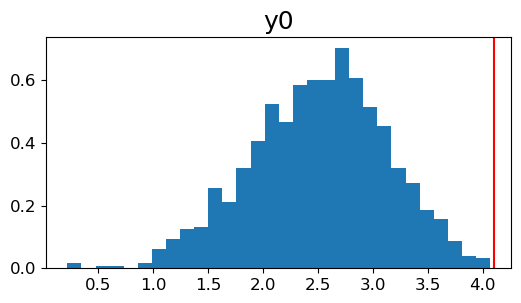

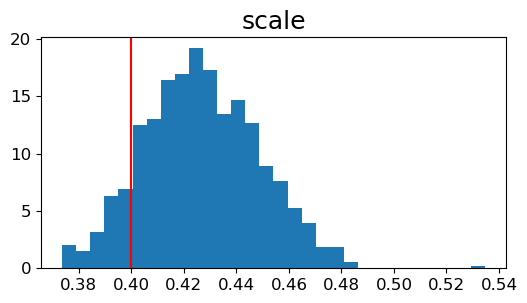

In [11]:
ar_ou_model = Model('AR(1) - Mean reversion')
mean_node = ar_ou_model.add_node('mean', distribution=dx.Normal(loc=0.0, scale=1.0))
reversion_node = ar_ou_model.add_node('reversion', distribution=dx.Normal(loc=0.0, scale=1.0))
y0_node = ar_ou_model.add_node('y0', dx.Normal(loc=jnp.zeros((1, )), scale=jnp.ones((1, ))))
scale_node = ar_ou_model.add_node('scale', distribution=dx.Transformed(dx.Normal(loc=0.0, scale=1.0), tfb.Exp()))

y_node = ar_ou_model.add_node('y(t)', 
                              distribution=AutoRegressionFactory(ar_fn=ar_ou_fn), 
                              observations=sample, 
                              parents=dict(mean=mean_node, 
                                           reversion=reversion_node, 
                                           y0=y0_node, 
                                           scale=scale_node))

step_fns = dict(mean=normal_random_walk, 
                reversion=normal_random_walk, 
                y0=normal_random_walk, 
                scale=normal_random_walk)
step_fn_params = dict(mean=dict(sigma=0.5), 
                      reversion=dict(sigma=0.3), 
                      y0=dict(sigma=0.5), 
                      scale=dict(sigma=0.1))

gibbs = gibbs_sampler(ar_ou_model, step_fns=step_fns, step_fn_params=step_fn_params)
engine = SMCInference(model=ar_ou_model, mcmc_kernel=gibbs, num_particles=1000, num_mutations=100, num_chains=1)
results = engine.run(jrnd.PRNGKey(1234))

nbins = 30
for var in step_fns.keys():
    plt.figure(figsize=(6, 3))
    plt.hist(results['final_state'].particles[var], density=True, bins=nbins)
    plt.axvline(x=state[var], color='r');
    plt.title(var)

# Earthquake counts per year

See https://online.stat.psu.edu/stat501/book/export/html/996


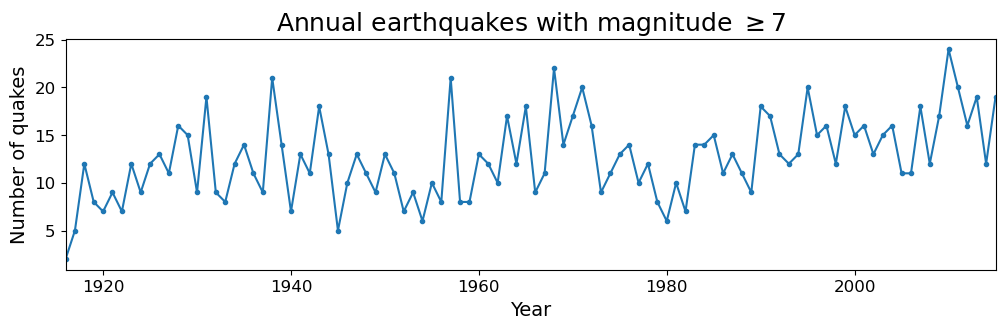

In [3]:
import pandas as pd

quakes_data = pd.read_csv('https://online.stat.psu.edu/onlinecourses/sites/stat501/files/data/earthquakes.txt', sep='\t')
time = jnp.asarray(quakes_data['Year'].to_numpy())
quakes = jnp.asarray(quakes_data['Quakes'].to_numpy(), dtype=jnp.float64)
n = len(quakes)

plt.figure(figsize=(12, 3))
ax = plt.gca()
ax.plot(time, quakes, '.-')
ax.set_xlim([time[0], time[-1]])
ax.set_xlabel('Year')
ax.set_ylabel('Number of quakes')
ax.set_title(r'Annual earthquakes with magnitude $\geq 7$');

In [4]:
def ar_fn(y_prev, intercept, coefficients, **kwargs):
    return intercept + jnp.dot(coefficients, y_prev)

#

order = 3

quake_model = Model('Mauna Loa CO2')
coefficients_node = quake_model.add_node('coefficients', distribution=dx.Normal(loc=jnp.zeros((order, )), scale=jnp.ones((order, ))))
y0_node = quake_model.add_node('y0', dx.Normal(loc=jnp.zeros((order, )), scale=10*jnp.ones((order, ))))
intercept_node = quake_model.add_node('intercept', dx.Normal(loc=0.0, scale=10.0))
scale_node = quake_model.add_node('scale', distribution=dx.Transformed(dx.Normal(loc=0.0, scale=0.1), tfb.Exp()))
T_node = quake_model.add_node('T', observations=n)  # needed for predictions

y_node = quake_model.add_node('y(t)', 
                            distribution=AutoRegressionFactory(ar_fn=ar_fn), 
                            observations=quakes, 
                            parents=dict(coefficients=coefficients_node,
                                         intercept=intercept_node,
                                         y0=y0_node, 
                                         scale=scale_node,
                                         T=T_node))

### Gibbs-in-SMC
step_fns = dict(coefficients=normal_random_walk, 
                y0=normal_random_walk,  
                intercept=normal_random_walk,  
                scale=normal_random_walk)
step_fn_params = dict(coefficients=dict(sigma=0.05*jnp.eye(order)),
                      y0=dict(sigma=3.0), 
                      intercept=dict(sigma=1.0), 
                      scale=dict(sigma=0.5))

gibbs = gibbs_sampler(quake_model, step_fns=step_fns, step_fn_params=step_fn_params)
num_particles = 3000
engine = SMCInference(model=quake_model, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=200, num_chains=1)
results = engine.run(jrnd.PRNGKey(123))
posterior = results['final_state'].particles

for var, value in results['final_info'].update_info.items():
    ar = jnp.mean(value.is_accepted)
    print(f'Acceptance rate for {var} is {ar:0.3f}')

for var, value in posterior.items():
    mu = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), value)
    sd = jax.tree_util.tree_map(lambda x: jnp.std(x, axis=0), value)
    print(f'{var}: {mu} ({sd})')

Acceptance rate for coefficients is 0.232
Acceptance rate for intercept is 0.319
Acceptance rate for scale is 0.286
Acceptance rate for y0 is 0.723
coefficients: [0.16632126 0.08149202 0.2722757 ] ([0.06942505 0.06974508 0.06875152])
intercept: 6.257199729859984 (1.0978970315984813)
scale: 2.6677599563556478 (0.12384966672099347)
y0: [ 4.95876752 -5.00099605 -7.91868779] ([7.4724353  7.42590679 7.73351579])


MLE coefficients taken from https://online.stat.psu.edu/stat501/book/export/html/996

In [5]:
mle_coef = [0.164, 0.071, 0.269]
mle_intercept = 6.45

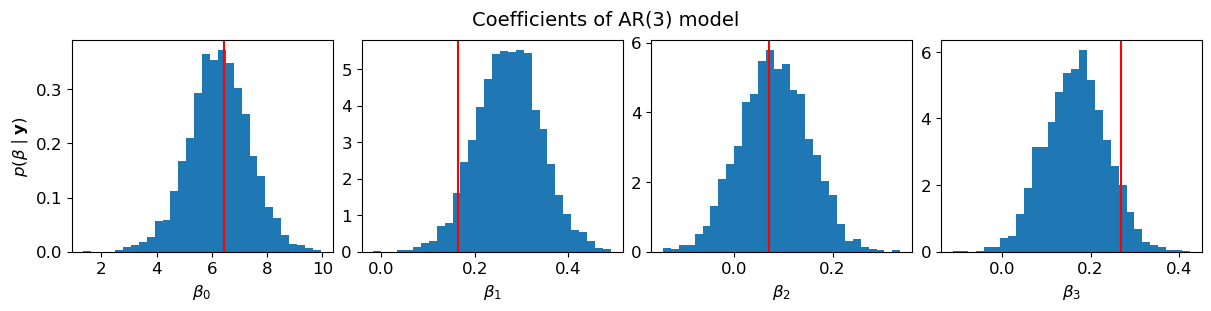

In [9]:
coefficients_posterior = posterior['coefficients'][:, ::-1]
nbins = 30
_, axes = plt.subplots(nrows=1, ncols=order+1, constrained_layout=True, figsize=(4*order, 3))
axes[0].hist(posterior['intercept'], density=True, bins=nbins)
axes[0].set_xlabel(r'$\beta_0$', fontsize=SMALL_SIZE)
axes[0].axvline(x=mle_intercept, color='r')
for i, ax in enumerate(axes[1:]):
    ax.hist(coefficients_posterior[:, i], density=True, bins=nbins)
    ax.set_xlabel(fr'$\beta_{i+1}$', fontsize=SMALL_SIZE)
    ax.axvline(x=mle_coef[i], color='r')
axes[0].set_ylabel(r'$p(\beta \mid \mathbf{y})$', fontsize=SMALL_SIZE)
plt.suptitle('Coefficients of AR(3) model', fontsize=MEDIUM_SIZE);

The model recovers the MLE coefficients nicely.